# P4 - Advanced Lane Finding #
## Udacity - Self Driving Car Nano-Degree ##

Submitted by - Vishal Rangras

In [1]:
#Basic Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import collections
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Disclaimer ###
I have used all the methods taught in the classroom Module of P4 to develop my understanding of Computer Vision and have applied the learning to this project. So I would like to give credit and attribution to the Udacity's Module and code base along with some folks at Slack and discussion forum who guided me whenever I got stuck somewhere.

I explicitly coded every step in simple python files and tested my code implementations. I did some trial and error to reach desired output. And then I combined all my code snippets into this Jupyter notebook to provide comprehensive code base as a part of project submission.

All in all, it was an amazing experience working on this project. Before this project, I was really afraid of Computer Vision as it was very new to me and was out of my comfort zone. After completion of this project, I have learned so many great things and I am proud that I got this amazing opportunity to explore the programming side of vision.

### Attributions ###

I would like to give credits to Jeremy Shanon, Roy Veshovda, Oleg Potkin and Vivek Yadav for their wonderful works and writeups on Advanced Lane Finding. I found their writeups extremely helpful in clearing my concepts for the 2nd iteration of project and its resubmission. Also there are many people and discussions going on slack which helped me directly or indirectly to reach to the next stage for my project. I have also adopted the diagnostic box and targeted search approach using Sanity Check from Oleg Potkin's work. 

### Initial Variables ###
In the following cell, I have declared some initial variables which will come handy for Camera Calibration. Also, I used some lists to store the processed images which then I ultimately used to prepare combined grid of images for the purposes of writeup.

In [2]:
#Initializing some required variables

imgpoints = [] # 2D points in image plane
objpoints = [] # 3D points in real world space

objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x, y coordinate

corner_images = []

undistorted_images = []

## Image Processing ##

All the functions required for image processing are declared in the following cell. I will describe them briefly here one by one.

1. **draw_corners**: Used to draw Chessboard Corners on the chess board images. Also, imgpoints and objpoints are added to list.
2. **undistort_img**: Based on the imgpoints and objpoints found in previous function draw_corners, the Camera Matrix, distortion coefficients, Radial distortion vector and tangential distortion vector are calculated. And then using this camera matrix and distortion coefficient, the input image is undistorted and returned.
3. **thresh**: This function is used to simply apply threshold computation on passed image along with threshold value inputs.
4. **colorthresh**: Applies color threshold to R channel and S channel images and then combines the pixels of this images.
5. **abs_sobel_thresh**: Applies Sobel operation along x or y axis with default kernal size of 3 and inputted thresholds.
6. **mag_thresh**: Applies the Gradient magnitude threshold with kernal size of 9 and threshold values of 30 and 200.
7. **dir_threshold**: Applies the Gradient Direction threshold with kernal size of 9 and threshold values of 0.7 and 1.3
8. **gradthresh**: This function calls all the gradient threshold functions discussed above and then combines the output of all the gradient threshold functions. I tried various combinations of different kinds of gradient thresholds and then ultimately chose the following combination: (Sobelx OR Mag_Gradient) AND (Sobely OR Mag_Gradient)
9. **combinethresh**: I have combined the color thresholding and gradient thresholding images in this function.
10. **warp**: By measuring pixel locations of the provided sample images, source and destination points were determined and then the perspective transform was applied to the processed image at this step.

** Please note that the functions are defined in the same order in which they will be applied to image / video processing pipeline. **

In [3]:
#Defining all the functions required for pipeline

def draw_corners(img, nx=9, ny=6):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        corner_images.append(img)
    else:
        corner_images.append(img)
        
def undistort_img(img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def thresh(img, thresh=(0,255)):
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

def colorthresh(img):
    r_channel = img[:,:,2]
    r_thresh = thresh(r_channel, thresh=(200,255))
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh = thresh(s_channel, thresh=(160,255))
    color_combined = np.zeros_like(s_thresh)
    color_combined[((r_thresh==1)|(s_thresh==1))] = 1
    return color_combined
    #return s_thresh

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img = img[:,:,2]
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, 7)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, 7)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary

def mag_thresh(img, kernel=7, mag_thresh=(40, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img = img[:,:,2]
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, kernel=7, thresh=(0.65, 1.05)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img = img[:,:,2]
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def gradthresh(img):
    
    img = cv2.GaussianBlur(img, (5, 5), 0)
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=60, thresh_max=255)
    mag_binary = mag_thresh(img)
    dir_binary = dir_threshold(img)

    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx==1)&(grady==1))|((mag_binary == 1)&(dir_binary == 1))] = 1
    #grad_combined[((gradx==1)|(mag_binary == 1)) | ((grady == 1)&(dir_binary == 1))] = 1
    #grad_combined[((gradx==1)&(mag_binary == 1)) | ((grady == 1)&(dir_binary == 1))] = 1
    #grad_combined[((gradx==1)|(mag_binary == 1))] = 1
    #grad_combined[((gradx==1)|(mag_binary == 1)) & ((grady == 1)|(mag_binary == 1))] = 1
    #grad_combined[((gradx==1)|(mag_binary == 1)) & (grady == 1)] = 1
    
    return grad_combined

def combinethresh(grad_thresh, color_thresh):
    combined_color_grad = np.zeros_like(grad_thresh)
    combined_color_grad[(grad_thresh==1) | (color_thresh==1)] = 1
    return combined_color_grad

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def warp(img):
    #top right, bottom right, bottom left, top left
    src = np.float32([[180, img.shape[0]], [575, 460], 
                      [705, 460], [1150, img.shape[0]]])
    # Define 4 destination points
    dst = np.float32([[320, img.shape[0]], [320, 0], 
                      [960, 0], [960, img.shape[0]]])
    
    #src = np.float32([[490, 482],[810, 482], [1250, 720],[40, 720]])
    #dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    imshape = warped_img.shape
    vertices = np.array([[(200, imshape[0]), (200, 0), (imshape[1] - 200, 0), 
                      (imshape[1]-200, imshape[0])]], dtype=np.int32)
    masked_img = region_of_interest(warped_img, vertices)
    return masked_img, M, Minv


## Finding the Lane Line ##

Here comes the real business of this project: ** Detection of Lane Lines **
Following functions are defined in following code cell which will be useful to detect line and get desired measurements:

1. **find_lane**: This function takes a pre-processed binary warped image of the road. I used the histogram and sliding window approach for Lane Detection instead of Convolutional approach. As explained in the video lectures, I computed the histogram on the lower half of binary warped image as a starting point. Based on the determined peaks of the histogram and calculation of midpoint of the image, left and right base pixels were determined. The number of windows were provided as a variable which can be altered if needed. However, I used the same value of 9 for sliding window. The window height was computed by dividing the total image height with number of sliding windows. Then nonzero pixels in x as well as y dimension were identified and stored in corresponding array variables. The margin and minpix variables were defined which can be altered to increase / decrease the accuracy of whether to consider the given pixel as part of lane line or not.
    
    Then after, a for loop iterates for each window such that the window slides from bottom of the image to the top of the image. For each iteration, the Window boundaries were identified and highlighted with rectangle box around them on left as well as right side lane line. Then the nonzero pixels within the window were identified and stored for future processing.
    
    After completion of window iterations, the lane indices were been retrived from overall non-zero pixels so that the indices constitute only of the part of Lane Lines and rest of the pixel information can be ignored. np.polyfit was then used to plot a line of 2nd degree polynomial through Lane Indices for left as well as right lane. The computed lane line data was then returned from the function so that it can be used for next step.
    
2. **calculate_curvature_offset**: Based on the calculations and formulae provided in video lectures, the curvature of the road along with the offset of vehicle from centre of the road is been computed in this method. These values are then returned by the function.

3. **draw_lane**: The lane information returned by find_lane() function and curvature and offset information returned from its respective function are used to draw line and plot the information text on original source image in this function. The original source image is provided in undistorted form along with Minv value which is used to apply inverse perspective transform again so that lanes can be drawn on original image. The undistorted image is needed to draw the lane lines on them as a final output. This functionally basically performs the desired annotation of lane, curvature and offset information on image / video.

In [4]:
class Line():
    def __init__(self):
        # Was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(12*[0.0, 0.0, 0.0], 12)
        # Average x values of the fitted line over the last n iterations
        self.bestx = None
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Radius of curvature of the line in some units (meters)
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None

In [5]:
def find_base(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, midpoint, rightx_base
    
def find_lane(binary_warped):
    lines_detected = False
    
    leftx_base, midpoint, rightx_base = find_base(binary_warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    
    #Will start the search from scratch for first frame and then will use margin window
    #If the sanity fails then will search from scratch
    if(left_lane.detected == False) or (right_lane.detected == False):
        
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        left_lane.detected = True
        right_lane.detected = True
    else:
        left_lane_inds = ((nonzerox > (left_lane.current_fit[0] * (nonzeroy**2) + 
                                       left_lane.current_fit[1] * nonzeroy + 
                                       left_lane.current_fit[2] - margin)) & 
                          (nonzerox < (left_lane.current_fit[0] * (nonzeroy**2) + 
                                       left_lane.current_fit[1] * nonzeroy + 
                                       left_lane.current_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_lane.current_fit[0] * (nonzeroy**2) + 
                                        right_lane.current_fit[1] * nonzeroy + 
                                        right_lane.current_fit[2] - margin)) & 
                           (nonzerox < (right_lane.current_fit[0] * (nonzeroy**2) + 
                                        right_lane.current_fit[1] * nonzeroy + 
                                        right_lane.current_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    #Saving successful pixel position values to the respective Line objects
    if (len(leftx) < 1500):
        leftx = left_lane.allx
        lefty = left_lane.ally
        left_lane.detected = False
    else:
        left_lane.allx = leftx
        left_lane.ally = lefty
    if (len(rightx) < 1500):
        rightx = right_lane.allx
        righty = right_lane.ally
        right_lane.detected = False
    else:
        right_lane.allx = rightx
        right_lane.ally = righty
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Sanity check
    if (left_lane.current_fit[0] == False):
        left_lane.current_fit = left_fit
        right_lane.current_fit = right_fit
        
    if (abs(left_lane.current_fit[1] - left_fit[1]) > 0.18):
        left_lane.current_fit = left_lane.best_fit
        left_lane.detected = False
    else:
        left_lane.current_fit = left_fit
        left_lane.recent_xfitted.pop()
        left_lane.recent_xfitted.appendleft(left_lane.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in left_lane.recent_xfitted:
            avg = avg + element
        left_lane.best_fit = avg / (len(left_lane.recent_xfitted))
        
    if (abs(right_lane.current_fit[1] - right_fit[1]) > 0.18):
        right_lane.current_fit = right_lane.best_fit
        right_lane.detected = False
    else:
        right_lane.current_fit = right_fit
        right_lane.recent_xfitted.pop()
        right_lane.recent_xfitted.appendleft(right_lane.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in right_lane.recent_xfitted:
            avg = avg + element
        right_lane.best_fit = avg / (len(right_lane.recent_xfitted))
        
    if (abs(right_lane.current_fit[1] - right_fit[1]) > 0.38 and
        abs(left_lane.current_fit[1] - left_fit[1]) < 0.1):
        right_lane.current_fit[0] = left_lane.current_fit[0]
        right_lane.current_fit[1] = left_lane.current_fit[1]
        right_lane.current_fit[2] = left_lane.current_fit[2] + 600
        right_lane.recent_xfitted.pop()
        right_lane.recent_xfitted.appendleft(right_lane.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in right_lane.recent_xfitted:
            avg = avg + element
        right_lane.best_fit = avg / (len(right_lane.recent_xfitted))
        
    if (abs(left_lane.current_fit[1] - left_fit[1]) > 0.38 and
        abs(right_lane.current_fit[1] - right_fit[1]) < 0.1):
        left_lane.current_fit = left_fit
        left_lane.recent_xfitted.pop()
        left_lane.recent_xfitted.appendleft(left_lane.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in left_lane.recent_xfitted:
            avg = avg + element
        left_lane.best_fit = avg / (len(left_lane.recent_xfitted))
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_lane.current_fit[0]*ploty**2 + left_lane.current_fit[1]*ploty + left_lane.current_fit[2]
    right_fitx = right_lane.current_fit[0]*ploty**2 + right_lane.current_fit[1]*ploty + right_lane.current_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx, out_img
    
def calculate_curvature_offset(ploty, lefty, righty, leftx, rightx, w, h):
    y_eval = np.max(ploty)
    lane_width_pix = w * 0.57
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvrad = np.mean([left_curverad, right_curverad])
    
    image_centre = 1280/2 * xm_per_pix
    
    left_lane_bottom = (left_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                        left_fit_cr[1] * (y_eval * ym_per_pix) + left_fit_cr[2])
    
    right_lane_bottom = (right_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                         right_fit_cr[1] * (y_eval * ym_per_pix) + right_fit_cr[2])
    
    vehicle_centre = float(right_lane_bottom + left_lane_bottom) / 2
    
    #vehicle_centre = np.mean([left_fit_cr, right_fit_cr])
    
    vehicle_offset = (image_centre - vehicle_centre)
    
    return curvrad, vehicle_offset
    
def draw_lane(binary_warped, out_img, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    img_size = (color_warp.shape[1], color_warp.shape[0])
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size)

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    x_offset = result.shape[1] - 320 - 30
    y_offset = 30
    thumb = cv2.resize(out_img, (320, 200), interpolation = cv2.INTER_CUBIC)
    result[y_offset:y_offset + thumb.shape[0], x_offset:x_offset + thumb.shape[1]] = thumb
    
    
    cv2.putText(result, 'Distance from centre: {:.2f} m'.format(vehicle_offset), (100,80), fontFace = 16,\
                    fontScale = 1.5, color=(255,255,255), thickness = 4)
        
    cv2.putText(result, 'Radius of Curvature {} m'.format(int(curverad)), (120,140),
             fontFace = 16, fontScale = 1.5, color=(255,255,255), thickness = 4)
    
    return result

### Camera Caliberation and Image Processing ###

Applied camera caliberation to all the provided chessboard images.
Then applied all the pre-processing operations to those images.

In [6]:
#To Calibrate Camera
for file in os.listdir("camera_cal/"):
    img = mpimg.imread("camera_cal/"+file)
    draw_corners(img)

In [12]:
left_lane = Line()
right_lane = Line()
path = "test_images/"
file = "test6.jpg"
img = cv2.imread(path+file)
undist = undistort_img(img)
grad_thresholded = gradthresh(undist)
color_thresholded = colorthresh(undist)
combined_thresholded = combinethresh(grad_thresholded, color_thresholded)
warped_img, M, Minv = warp(combined_thresholded)

## Code to plot input image and processed images in grid ##

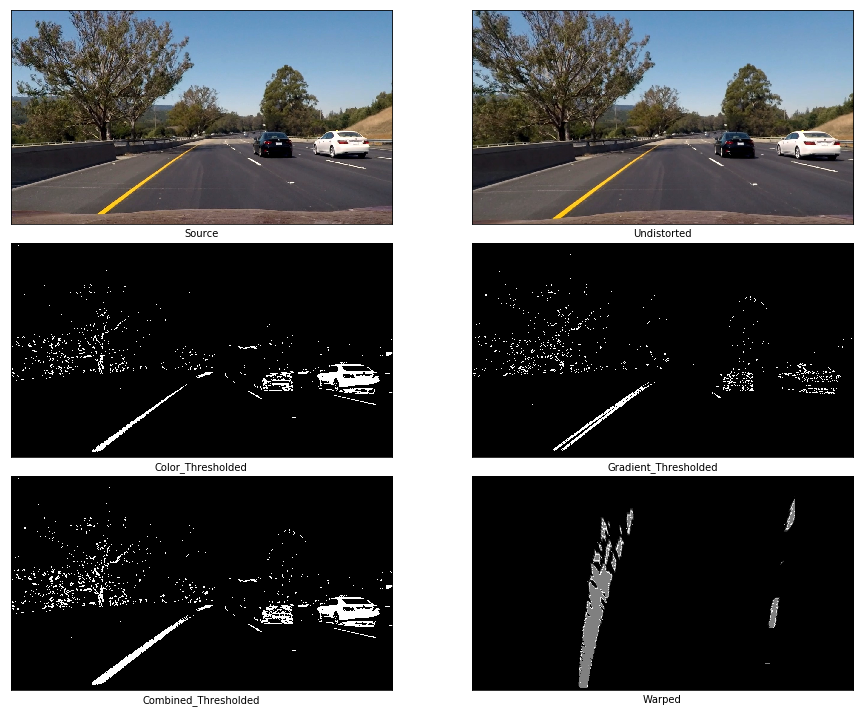

In [13]:
processed_images = plt.figure(figsize=(14,10))

axis = processed_images.add_subplot(3,2,1)
axis.set_xlabel("Source")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

axis = processed_images.add_subplot(3,2,2)
axis.set_xlabel("Undistorted")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))

axis = processed_images.add_subplot(3,2,3)
axis.set_xlabel("Color_Thresholded")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(color_thresholded, cmap="gray")

axis = processed_images.add_subplot(3,2,4)
axis.set_xlabel("Gradient_Thresholded")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(grad_thresholded, cmap="gray")

axis = processed_images.add_subplot(3,2,5)
axis.set_xlabel("Combined_Thresholded")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(combined_thresholded, cmap="gray")

axis = processed_images.add_subplot(3,2,6)
axis.set_xlabel("Warped")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(warped_img, cmap="gray")

processed_images.tight_layout(h_pad=0, w_pad=0)
processed_images.savefig('output_images/processed_images.png')

## Lane Detection on a single image ##

The lanes were detected on binary warped image which is shown in the grid above. After the detection of Lane and Measurement of road curvature and offset, the information was annotated to the original image which is displayed below.

1168.32049884 m -0.19704607794968831 m


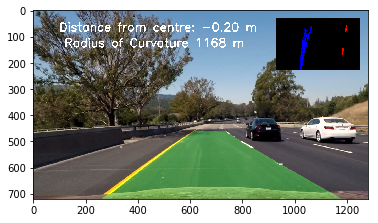

In [18]:
ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx, out_img = find_lane(warped_img)
curverad, vehicle_offset = calculate_curvature_offset(ploty, lefty, righty, leftx, rightx, undist.shape[1], undist.shape[0])
print (curverad,"m",vehicle_offset,"m")
result = draw_lane(warped_img, out_img, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Image Processing Pipeline ##

Basically calls all the functions defined above in the desired sequence to successfully detect lane lines on the image.

In [19]:
def processing_pipeline(img):
    undist = undistort_img(img)
    grad_thresholded = gradthresh(undist)
    color_thresholded = colorthresh(undist)
    combined_thresholded = combinethresh(grad_thresholded, color_thresholded)
    warped_img, M, Minv = warp(combined_thresholded)
    ploty, lefty, righty, leftx, rightx, left_fitx, right_fitx, out_img = find_lane(warped_img)
    curverad, vehicle_offset = calculate_curvature_offset(ploty, lefty, righty, leftx, rightx, undist.shape[1], undist.shape[0])
    result = draw_lane(warped_img, out_img, undist, Minv, ploty, left_fitx, right_fitx, curverad, vehicle_offset)
    return result
    

## Video Processing ##
In the following section, the video was provided to the processing pipeline and the Lane Line Detection was carried out in the output video.

In [20]:
project_video_processed = 'project_video_processed_R2.mp4'
video = VideoFileClip("project_video.mp4")
left_lane = Line()
right_lane = Line()
processed_clip = video.fl_image(processing_pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(project_video_processed, audio=False)

[MoviePy] >>>> Building video project_video_processed_R2.mp4
[MoviePy] Writing video project_video_processed_R2.mp4


100%|██████████████████████████████████████████▉| 1260/1261 [51:44<00:02,  2.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed_R2.mp4 

Wall time: 51min 47s


In [21]:
project_video_processed = 'project_video_processed_R2.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_processed))